In [1]:
import os
import json
import numpy as np
import torch
import result
import pandas as pd
from rnn_model import LSTMNet, GRUNet
from utils import DotDict, Logger, rmse, rmse_tensor, boolean_string, get_dir, get_time, next_dir, model_dir, get_model
from get_dataset import get_time_data, get_stnn_data
from stnn import *
import matplotlib.pyplot as plt
from matplotlib import axis
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


## Data

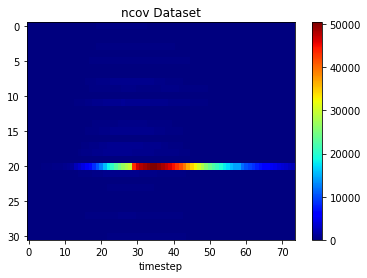

In [16]:
datadir = 'data'
dataset = 'ncov_confirmed'
data = get_time_data(datadir, dataset).numpy()

plt.figure('ncov Dataset')
plt.imshow(data[:, :, 0].T, aspect='auto', cmap='jet')
plt.title('ncov Dataset')
plt.xlabel('timestep')
plt.colorbar()

## Mode List

In [87]:
jar_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'jar0426'))
print(jar_folder)
jar_result = result.Printer(jar_folder)
pd.options.display.max_rows = None
# a = jar_result.get_df(col=['train_loss', 'test_loss', 'mode']).sort_values('test_loss', ascending=True)
jar_df = jar_result.get_df(col=['train_loss', 'test_loss', 'score_true_confirmed', 'mode', 'nhid', 'nlayers', 'nz', 'activation']).sort_values('score_true_confirmed', ascending=True)
jar_df

d:\Jupyter_Documents\ML-code\research_code\output\jar0426
ori-stnn_04-27-13-31-44  x
ori-stnn_04-27-13-32-30  x
ori-stnn_04-27-13-57-56  x
ori-stnn_04-27-14-11-11  x
ori-stnn_04-27-15-00-07  x
ori-stnn_04-27-15-04-20  x
v3-stnn_04-27-14-14-49  x
v3-stnn_04-27-14-18-45  x
v3-stnn_04-27-14-18-47  x
v3-stnn_04-27-14-23-46  x
v3-stnn_04-27-14-31-17  x
v3-stnn_04-27-15-26-32  x
v3-stnn_04-27-15-27-40  x


,train_loss,test_loss,score_true_confirmed,mode,nhid,nlayers,nz,activation,used_model
v3-stnn_04-27-04-02-15,0.270378,0.780698,4442.46,discover,200,2,10,sigmoid,v3
v2-stnn_04-27-00-56-16,0.036333,0.995123,7929.92,refine,200,2,10,tanh,v2
ori-stnn_04-27-02-31-30,0.0692564,1.11642,8206.72,refine,200,2,10,sigmoid,ori
v3-stnn_04-27-04-02-00,0.149408,1.51485,8542.03,discover,200,2,10,sigmoid,v3
v3-stnn_04-27-02-12-58,0.132822,1.48072,8732.26,refine,200,2,10,sigmoid,v3
ori-stnn_04-27-00-52-05,0.0431675,1.12699,8749.04,None,200,2,10,sigmoid,ori
v2-stnn_04-27-01-14-15,0.252551,1.4037,8854.79,discover,200,2,10,tanh,v2
v3-stnn_04-27-06-55-08,0.245962,1.47121,9037.07,refine,20,2,10,sigmoid,v3
ori-stnn_04-27-02-31-43,0.633355,1.4627,9118.5,refine,200,2,10,tanh,ori
v1-stnn_04-27-01-00-40,0,1.37048,9491.07,discover,200,2,10,sigmoid,v1


## Jar Exp 

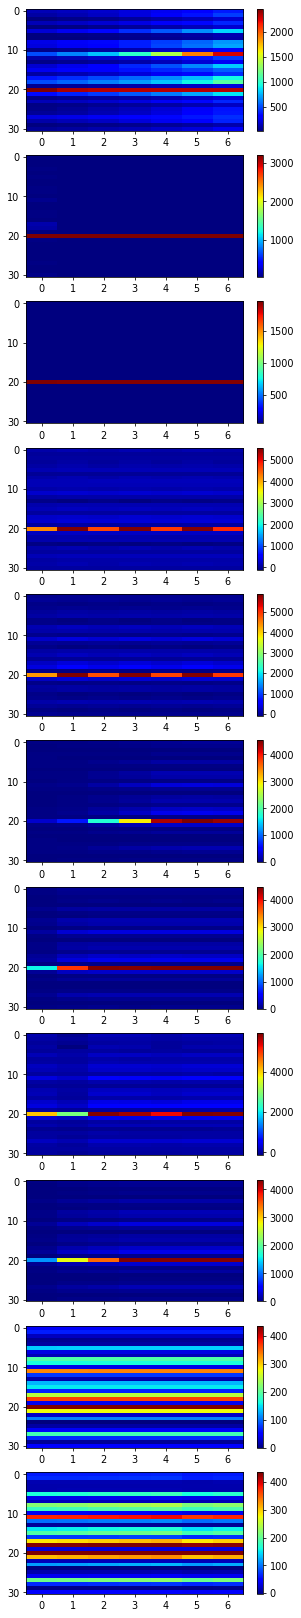

In [100]:
jar_exp = {}
jar_exp['STNN'] = 'ori-stnn_23-51-04-04-01'
jar_exp['STNN-R'] = 'ori-stnn_00-54-05-04-34'
jar_exp['STNN-D'] = 'ori-stnn_10-40-05-04-54'
jar_exp['STNN-v2'] = 'input-stnn_23-51-04-04-01'
jar_exp['STNN-v2-R'] = 'input-stnn_23-53-04-04-56'
jar_exp['STNN-v2-D'] = 'input-stnn_10-40-05-04-03'
jar_exp['STNN-v1'] = 'concat-stnn_10-40-05-04-11'
jar_exp['STNN-v1-R'] = 'concat-stnn_23-53-04-04-30'
jar_exp['STNN-v1-D'] = 'concat-stnn_10-35-05-04-21'
jar_exp['LSTM'] = 'keras-rnn_10-39-05-04-16'
jar_exp['GRU'] = 'keras-rnn_00-45-05-04-30'
jar = {}
jar_pred = {}
for k, v in jar_exp.items():
    jar[k] = result.Exp(v, folder)
    jar_pred[k] = jar[k].pred().numpy().T
plt.figure('Results', figsize=(5, 30), dpi=70)

# plt.subplot(11, 3, 1)
# plt.imshow(test_data, aspect='auto', cmap='jet')
# plt.colorbar()
# plt.title('ground truth')

for i, exp in enumerate(jar_pred):
    plt.subplot(11, 1, i + 1)
    plt.imshow(jar_pred[exp], aspect='auto', cmap='jet')
    plt.colorbar()

    # plt.subplot(11, 3, i * 3 + 3)
    # plt.imshow(np.abs(test_data - pred[exp]), aspect='auto')
    # plt.colorbar()
    # plt.title('{} absolute error'.format(exp))

In [105]:
jar_lis = []
for k, v in jar_exp.items():
    jar_lis.append(v)
jar_df.loc[jar_lis].to_excel('jan.xls')

## Feb Exp

In [4]:
feb_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'feb'))
feb_result = result.Printer(feb_folder)
pd.options.display.max_rows = None
# a = feb_result.get_df(col=['train_loss', 'test_loss', 'mode']).sort_values('test_loss', ascending=True)
feb_df = feb_result.get_df(col=['train_loss', 'test_loss', 'true_loss', 'mode', 'nhid', 'nlayers', 'nz', 'dropout_d']).sort_values('test_loss', ascending=True)
feb_df

input-stnn_04-11-15-52-11  x
input-stnn_04-11-15-52-13  x
input-stnn_04-11-15-52-14  x
input-stnn_04-11-15-52-15  x
input-stnn_04-11-15-52-16  x
input-stnn_04-11-15-52-17  x
input-stnn_04-11-15-52-18  x
input-stnn_04-11-15-52-19  x
input-stnn_04-11-15-52-20  x
input-stnn_04-11-15-52-21  x
input-stnn_04-11-15-52-22  x
input-stnn_04-11-15-52-23  x
input-stnn_04-11-15-52-24  x
input-stnn_04-12-13-36-27  x


,train_loss,test_loss,true_loss,mode,nhid,nlayers,nz,dropout_d
input-stnn_10-46-05-04-09,0.0298557,0.0391682,257.44,refine,20,4,2,0.9
input-stnn_10-47-05-04-02,0.0356295,0.0407576,267.886,discover,20,4,2,0.9
input-stnn_10-45-05-04-27,0.0165179,0.0422783,277.881,None,20,4,2,0.9
input-stnn_04-11-19-43-08,0.00610349,0.0456122,299.793,refine,20,2,10,0.5
input-stnn_04-08-00-23-46,0.0208644,0.0591165,388.553,None,20,2,10,0.5
ori-stnn_00-09-05-04-39,0,0.0624913,410.735,refine,20,2,10,0.5
input-stnn_04-12-10-16-42,0.00334012,0.0628906,413.359,discover,20,2,10,0.5
input-stnn_04-11-23-49-19,0.00541258,0.0655475,430.822,discover,20,2,10,0.5
input-stnn_23-54-04-04-49,0.00515367,0.0700511,460.423,refine,200,2,10,0.5
concat-stnn_04-08-00-06-16,0.0109036,0.0710506,466.992,None,20,2,10,0.5


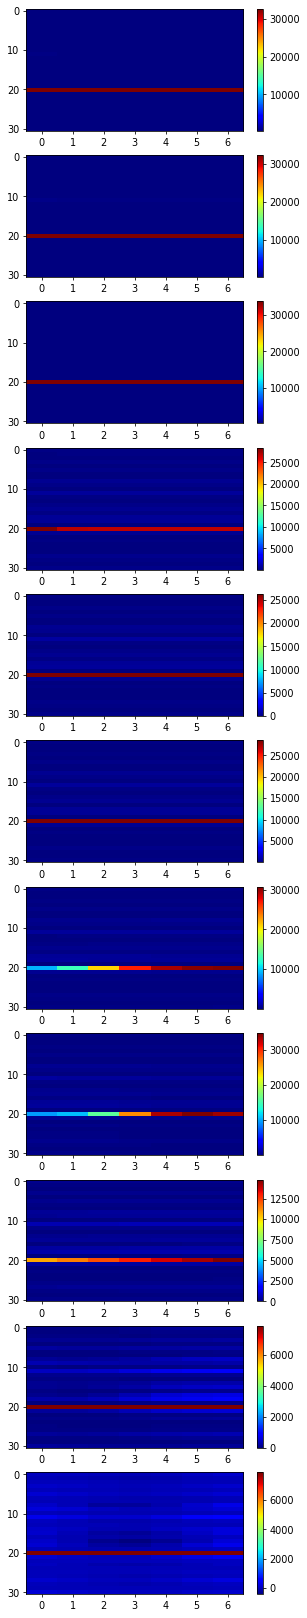

In [92]:
feb_exp = {}
feb_exp['STNN'] = 'ori-stnn_00-07-05-04-46'
feb_exp['STNN-R'] = 'ori-stnn_00-09-05-04-39'
feb_exp['STNN-D'] = 'ori-stnn_00-35-05-04-01'
feb_exp['STNN-v2'] = 'input-stnn_10-45-05-04-27'
feb_exp['STNN-v2-R'] = 'input-stnn_10-46-05-04-09'
feb_exp['STNN-v2-D'] = 'input-stnn_10-47-05-04-02'
feb_exp['STNN-v1'] = 'concat-stnn_10-38-05-04-09'
feb_exp['STNN-v1-R'] = 'concat-stnn_00-06-05-04-07'
feb_exp['STNN-v1-D'] = 'concat-stnn_10-42-05-04-04'
feb_exp['LSTM'] = 'keras-rnn_00-09-05-04-14'
feb_exp['GRU'] = 'keras-rnn_01-16-05-04-26'
feb = {}
feb_pred = {}
for k, v in feb_exp.items():
    feb[k] = result.Exp(v, feb_folder)
    feb_pred[k] = feb[k].pred().numpy().T
plt.figure('Results', figsize=(5, 30), dpi=70)

# plt.subplot(11, 3, 1)
# plt.imshow(test_data, aspect='auto', cmap='jet')
# plt.colorbar()
# plt.title('ground truth')

for i, exp in enumerate(feb_pred):
    plt.subplot(11, 1, i + 1)
    plt.imshow(feb_pred[exp], aspect='auto', cmap='jet')
    plt.colorbar()

    # plt.subplot(11, 3, i * 3 + 3)
    # plt.imshow(np.abs(test_data - pred[exp]), aspect='auto')
    # plt.colorbar()
    # plt.title('{} absolute error'.format(exp))

In [104]:
feb_lis = []
for k, v in feb_exp.items():
    feb_lis.append(v)
feb_df.loc[feb_lis].to_excel('feb.xls')

## Mar Exp

In [5]:
mar_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'mar'))
mar_result = result.Printer(mar_folder)
pd.options.display.max_rows = None
# a = mar_result.get_df(col=['train_loss', 'test_loss', 'mode']).sort_values('test_loss', ascending=True)
mar_df = mar_result.get_df(col=['train_loss', 'test_loss', 'true_loss', 'mode', 'nhid', 'nlayers', 'nz', 'dropout_d']).sort_values('test_loss', ascending=True)
mar_df

input-stnn_04-12-13-07-45  x


,train_loss,test_loss,true_loss,mode,nhid,nlayers,nz,dropout_d
ori-stnn_00-04-05-04-51,0,0.0208291,61.0644,None,20,2,10,0.5
keras-rnn_02-07-05-04-11,0.157529,0.0222844,65.3308,NaN,100,4,NaN,NaN
keras-rnn_10-43-05-04-05,0.15754,0.0223458,65.5108,NaN,10,4,NaN,NaN
keras-rnn_01-14-05-04-01,0.157529,0.0223694,65.5801,NaN,100,2,NaN,NaN
keras-rnn_01-27-05-04-36,0.157529,0.0226362,66.3623,NaN,100,4,NaN,NaN
keras-rnn_00-04-05-04-32,0.393322,0.0227362,66.6554,NaN,100,2,NaN,NaN
keras-rnn_00-53-05-04-25,0.157528,0.022751,66.6988,NaN,100,2,NaN,NaN
keras-rnn_03-07-05-04-17,0.604055,0.0228147,66.8854,NaN,100,4,NaN,NaN
keras-rnn_02-32-05-04-50,0.604057,0.0228696,67.0464,NaN,100,2,NaN,NaN
keras-rnn_10-40-05-04-46,0.157534,0.0230558,67.5924,NaN,10,2,NaN,NaN


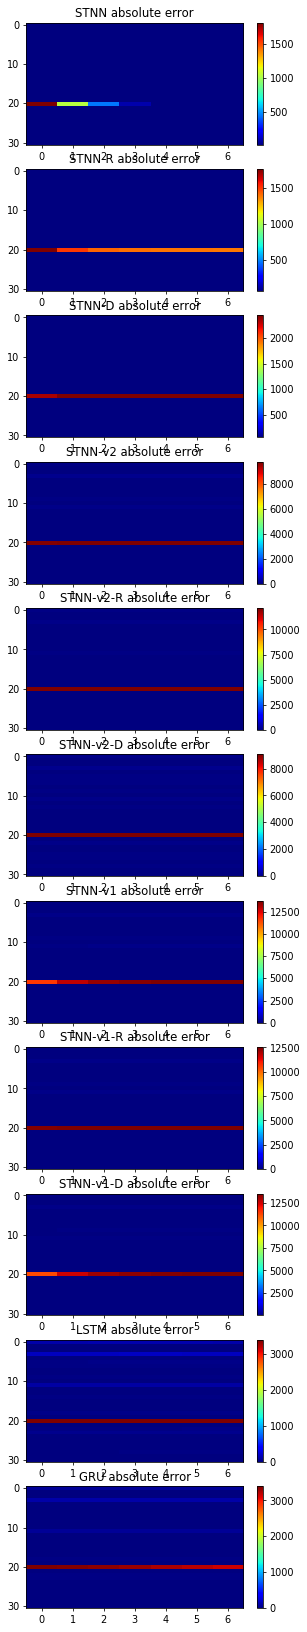

In [96]:
mar_exp = {}
mar_exp['STNN'] = 'ori-stnn_00-04-05-04-51'
mar_exp['STNN-R'] = 'ori-stnn_00-19-05-04-49'
mar_exp['STNN-D'] = 'ori-stnn_00-28-05-04-19'
mar_exp['STNN-v2'] = 'input-stnn_10-46-05-04-19'
mar_exp['STNN-v2-R'] = 'input-stnn_12-22-05-04-14'
mar_exp['STNN-v2-D'] = 'input-stnn_10-48-05-04-02'
mar_exp['STNN-v1'] = 'concat-stnn_12-21-05-04-12'
mar_exp['STNN-v1-R'] = 'concat-stnn_12-21-05-04-45'
mar_exp['STNN-v1-D'] = 'concat-stnn_12-22-05-04-26'
mar_exp['LSTM'] = 'keras-rnn_02-07-05-04-11'
mar_exp['GRU'] = 'keras-rnn_10-43-05-04-05'
mar = {}
mar_pred = {}
for k, v in mar_exp.items():
    mar[k] = result.Exp(v, mar_folder)
    mar_pred[k] = mar[k].pred().numpy().T
plt.figure('Results', figsize=(5, 30), dpi=70)

# plt.subplot(11, 3, 1)
# plt.imshow(test_data, aspect='auto', cmap='jet')
# plt.colorbar()
# plt.title('ground truth')

for i, exp in enumerate(mar_pred):
    plt.subplot(11, 1, i+1)
    plt.imshow(mar_pred[exp], aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))


    # plt.subplot(11, 3, i * 3 + 3)
    # plt.imshow(np.abs(test_data - pred[exp]), aspect='auto')
    # plt.colorbar()
    # plt.title('{} absolute error'.format(exp))

In [103]:
mar_lis = []
for k, v in mar_exp.items():
    mar_lis.append(v)
mar_df.loc[mar_lis].to_excel('mar.xlsx')

## Aids LSTM

In [8]:
folder_name = 'aids_LSTM'
model_name = get_model(folder_name)[1]
model_list = model_dir[folder_name]

### The Best Model 

In [ ]:
for model in model_list:
    model = LSTMNet()

In [5]:
outputdir = 'output'
exps = ['stnn']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_input, train_output), (test_input, test_data)  = dataset_factory(datadir, dataset, 700, 5)
    model = rnn(29, config['nhid'], config['nlayers'], 29, config['seq_length'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

## Results

In [6]:
predictions = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction = model.generate(test_input, 396)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
        print(prediction.size())
    print('RMSE {}:\t'.format(exp), mse)

torch.Size([396, 29, 1])
RMSE stnn:	 9.350045204162598


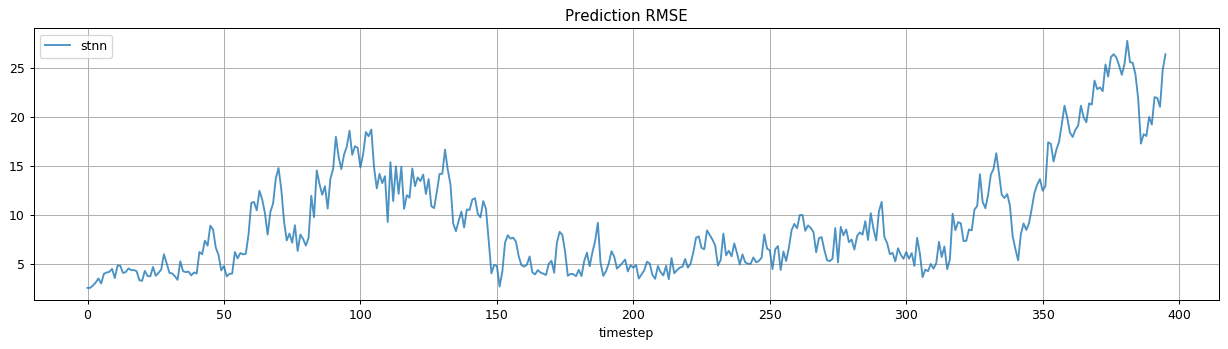

In [7]:
plt.figure('Test plots', figsize=(17, 4), dpi=90)
for exp in exps:
    with open(os.path.join(outputdir, exp, 'logs.json'), 'r') as f:
        logs = json.load(f)

    plt.plot([logs['test_epoch.ts.{}.rmse'.format(ts)][-1] for ts in range(396)], label=exp, alpha=0.8)

plt.grid()
plt.title('Prediction RMSE')
plt.xlabel('timestep')
plt.legend()

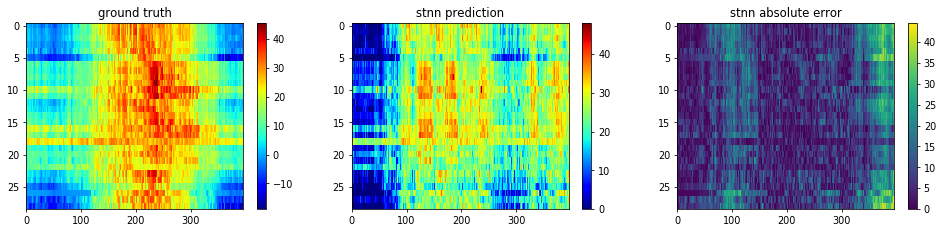

In [8]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(exps):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(predictions[exp].squeeze().numpy().T, aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(test_data.sub(predictions[exp]).abs().squeeze().numpy().T, aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))

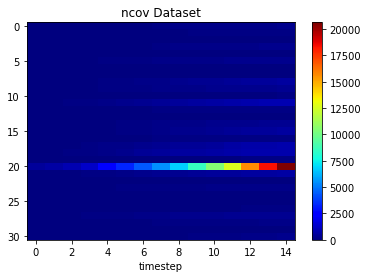

In [4]:
datadir = 'data'
dataset = 'jar'
data, _ = get_time_data(datadir, dataset)
data = data.numpy()

plt.figure('ncov Dataset')
plt.imshow(data[:, :, 0].T, aspect='auto', cmap='jet')
plt.title('ncov Dataset')
plt.xlabel('timestep')
plt.colorbar()

In [5]:
test = os.path.join(os.getcwd(), '..', 'output', 'jar')
test_exp = result.Exp(path=test, exp_name='keras-rnn_10-39-05-04-16')

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\Jupyter_Documents\\ML-code\\research_code\\ncov_RNN\\..\\output\\jar\\keras-rnn_10-39-05-04-16\\config.json'

## Japan Result

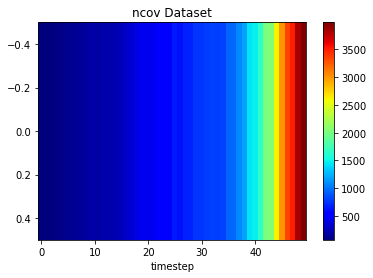

In [3]:
datadir = 'data'
dataset = 'japan'
data, _ = get_time_data(datadir, dataset)
data = data.numpy()

plt.figure('ncov Dataset')
plt.imshow(data[:, :, 0].T, aspect='auto', cmap='jet')
plt.title('ncov Dataset')
plt.xlabel('timestep')
plt.colorbar()

In [59]:
japan_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'japan'))
japan_result = result.Printer(japan_folder)
pd.options.display.max_rows = None
# a = japan_result.get_df(col=['train_loss', 'test_loss', 'mode']).sort_values('test_loss', ascending=True)
japan_df = japan_result.get_df(col=['train_loss', 'test_loss', 'true_loss', 'nhid', 'nlayers', 'seq_length', 'rnn_model']).sort_values('test_loss', ascending=True)
japan_df

,train_loss,test_loss,true_loss,nhid,nlayers,seq_length,rnn_model,used_model
keras-rnn_04-19-00-07-11,0.00503527,4.64058,2149.73,100,2,10,GRU,keras
keras-rnn_04-19-00-10-39,0.00630124,4.73613,2194,100,2,10,LSTM,keras
keras-rnn_04-19-00-19-10,0.00564007,4.77926,2213.98,100,2,10,LSTM,keras
keras-rnn_04-18-23-19-35,0.0102012,4.86692,2254.58,100,2,5,GRU,keras
keras-rnn_04-18-23-58-09,0.0489262,4.98469,2309.14,100,2,10,GRU,keras
keras-rnn_04-18-23-19-43,0.0292549,5.02916,2329.74,100,2,5,LSTM,keras
keras-rnn_04-18-23-29-24,0.0135406,5.09268,2359.17,100,2,5,LSTM,keras
keras-rnn_04-19-00-59-07,0.128336,5.16056,2390.61,100,2,2,GRU,keras
keras-rnn_04-19-01-06-28,0.115433,5.16818,2394.14,100,2,2,GRU,keras
keras-rnn_04-19-00-53-02,0.00785722,5.26793,2440.35,100,4,10,LSTM,keras


In [55]:
model_df = result.sorted_by_loss(japan_df)
exp_dir = result.get_exp_name(model_df)
pred_dir = result.get_pred(exp_dir, japan_folder)

{'keras': array([1482.        , 1661.        , 2018.        , 1045.265625  ,
        1045.26538086, 1045.26525879, 1045.26489258, 1045.26513672,
        1045.26513672, 1045.26611328])}

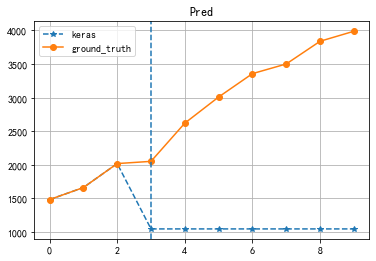

In [57]:
result.plot_pred_by_dir(pred_dir, data, start_time=3)

In [60]:
exp_dir

{'keras': 'keras-rnn_04-19-00-07-11'}

In [67]:
japan_exp = result.Exp(exp_dir['keras'], japan_folder)
japan_loss = japan_exp.train_loss()[0]


## Jar

ori-stnn_04-27-07-29-05  x
ori-stnn_04-27-07-31-52  x
ori-stnn_04-27-07-40-33  x
ori-stnn_04-27-08-55-48  x
ori-stnn_04-27-09-02-31  x
ori-stnn_04-27-12-27-26  x
v2-stnn_04-27-15-01-04  x
v3-stnn_04-27-07-23-18  x
v3-stnn_04-27-12-37-22  x
v3-stnn_04-27-13-17-29  x
v3-stnn_04-27-13-20-18  x
v3-stnn_04-27-13-48-36  x
v3-stnn_04-27-14-01-26  x


,train_loss,test_loss,true_loss,nhid,nlayers,datas_order,mode,nz,used_model
ori-stnn_04-27-01-08-01,0.22835,0.0497316,233.452,200,2,"[confirmed, dead]",default,10,ori
v2-stnn_04-27-07-00-38,0.026507,0.0587795,386.338,20,2,[confirmed],refine,10,v2
v2-stnn_04-27-07-26-14,0.0230377,0.0598242,393.204,20,2,[confirmed],discover,10,v2
v2-stnn_04-27-05-05-53,0.036042,0.060439,397.245,200,2,[confirmed],discover,10,v2
v3-stnn_04-27-01-09-25,0.165237,0.0624202,293.015,200,2,"[confirmed, dead]",default,10,v3
v1-stnn_04-27-08-52-27,0,0.0633606,416.448,20,2,[confirmed],default,10,v1
v2-stnn_04-27-02-13-00,0.0413761,0.067331,442.544,200,2,[confirmed],None,10,v2
v1-stnn_04-27-05-46-36,0,0.0726188,477.299,200,2,[confirmed],discover,10,v1
v1-stnn_04-27-09-05-11,0,0.0729529,479.495,20,2,[confirmed],refine,10,v1
v1-stnn_04-27-09-25-51,0,0.0745622,490.072,20,2,[confirmed],discover,10,v1


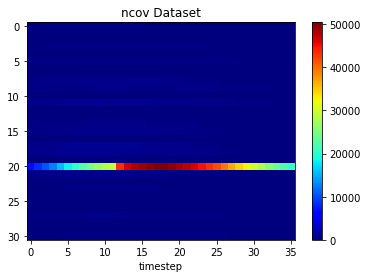

In [2]:
datadir = 'data'
dataset = 'feb'
data, _ = get_time_data(datadir, dataset)
data = data.numpy()

plt.figure('ncov Dataset')
plt.imshow(data[:, :, 0].T, aspect='auto', cmap='jet')
plt.title('ncov Dataset')
plt.xlabel('timestep')
plt.colorbar()

feb_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'feb0426'))
feb_result = result.Printer(feb_folder)
pd.options.display.max_rows = None
# a = feb_result.get_df(col=['train_loss', 'test_loss', 'mode']).sort_values('test_loss', ascending=True)
feb_df = feb_result.get_df(col=['train_loss', 'test_loss', 'true_loss', 'nhid', 'nlayers', 'datas_order', 'mode', 'nz']).sort_values('test_loss', ascending=True)
feb_df

In [8]:
model_df = result.sorted_by_loss(feb_df)
exp_dir = result.get_exp_name(model_df)
pred_dir,data = result.get_pred(exp_dir, feb_folder, train=True)
result.plot_pred_by_dir(pred_dir, data)

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\Jupyter_Documents\\ML-code\\research_code\\output\\feb0426\\ori-stnn_04-27-01-08-01\\model.pt'

In [13]:
exp_dir

{'ori': 'ori-stnn_04-27-01-08-01',
 'v2': 'v2-stnn_04-27-07-00-38',
 'v3': 'v3-stnn_04-27-01-09-25',
 'v1': 'v1-stnn_04-27-08-52-27'}

## Test load data

keras-rnn_05-02-00-03-32_9702  x
ori-stnn_05-03-00-07-34_6462  x
v2-stnn_05-03-00-07-15_6651  x


,train_loss,test_loss,true_loss,nhid,nlayers,datas_order,mode,nz,used_model
v2-stnn_05-03-00-05-59_0251,0.0720674,0.168769,886.256,0,1,[20200328_sum],None,1,v2
v1-stnn_04-27-11-31-56,0,0.194243,1020.03,0,1,[20200328_sum],refine,1,v1
v2-stnn_04-27-11-32-30,1.17187,0.2024,1062.86,0,1,[20200328_sum],refine,1,v2
ori-stnn_04-27-11-25-53,1.09637,0.239479,1257.57,0,1,[20200328_sum],None,1,ori
v3-stnn_04-27-11-32-35,1.05616,0.292137,1534.09,0,1,[20200328_sum],refine,1,v3
keras-rnn_04-27-21-17-19,0.538144,0.723582,3.65464,50,2,NaN,NaN,NaN,keras
ori-stnn_05-01-16-32-25_9684,1.99108,0.734668,3857.95,0,1,[20200328_sum],None,1,ori
v3-stnn_04-29-10-54-44,1.55745,0.736091,3865.42,0,1,[20200328_sum],None,1,v3
v1-stnn_05-01-10-42-51_7798,0,0.992624,92.3232,0,1,"[confirmed, cured, dead]",None,1,v1
ori-stnn_05-01-10-32-24_8324,0.944083,1.07215,99.7202,0,1,"[confirmed, cured, dead]",None,1,ori


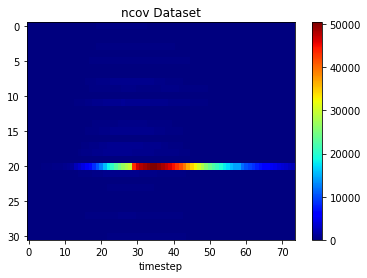

In [11]:
datadir = 'data'
dataset = 'ncov_confirmed'
data, _ = get_time_data(datadir, dataset)
data = data.numpy()

plt.figure('ncov Dataset')
plt.imshow(data[:, :, 0].T, aspect='auto', cmap='jet')
plt.title('ncov Dataset')
plt.xlabel('timestep')
plt.colorbar()

test_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'test'))
test_result = result.Printer(test_folder)
pd.options.display.max_rows = None
# a = test_result.get_df(col=['train_loss', 'test_loss', 'mode']).sort_values('test_loss', ascending=True)
test_df = test_result.get_df(col=['train_loss', 'test_loss', 'true_loss', 'nhid', 'nlayers', 'datas_order', 'mode', 'nz']).sort_values('test_loss', ascending=True)
test_df

{'test': array([26478.0838623 , 38150.56921387, 38160.15625   , 38451.74633789,
        38362.57519531, 38446.46191406, 38534.54309082, 38486.66955566,
        38719.29492188, 38742.23986816, 38827.6204834 , 38761.34057617,
        39246.19604492, 39311.32751465, 39367.20227051, 39200.99658203,
        39360.04931641, 39253.8190918 , 39442.98803711, 39137.48205566,
        38846.43603516, 38846.43603516, 38846.43603516, 38846.43603516,
        38846.43603516, 38846.43603516, 38846.43603516, 38846.43603516,
        38846.43603516, 38846.43603516, 38846.43603516, 38846.43603516,
        38846.43603516, 38846.43603516, 38846.43603516, 38846.43603516])}

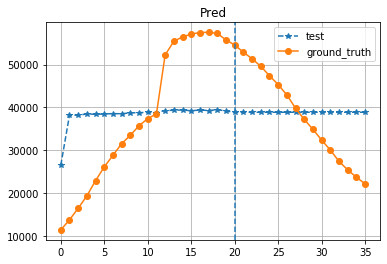

In [22]:
path = 'D:/Jupyter_Documents/ML-code/research_code/output/test'
exp_name = 'ori-stnn_05-03-17-01-14_3912'
# lambd =100
exp_dir = {'test': exp_name}
# exp_name = 'v2-stnn_05-03-00-05-59_0251'
# exp = Exp(exp_name, path)
# print(exp.plot_train_times().shape)
result.plot_pred_by_dir(exp_dir, path, train=True)

{'test': array([24648.40551758, 25389.57562256, 26711.04534912, 28398.07568359,
        30113.3036499 , 31639.97637939, 33060.71386719, 34311.49798584,
        35416.67614746, 36528.71166992, 37443.71893311, 37992.02026367,
        44903.79956055, 46387.79962158, 47090.1428833 , 47533.49536133,
        47604.55145264, 47657.74395752, 47953.83569336, 47216.18017578,
        50454.83569336, 44205.22192383, 40990.76098633, 39337.41821289,
        38491.07666016, 38104.24938965, 38004.57458496, 38005.79626465,
        38023.11096191, 38034.21936035, 38041.05773926, 38045.23742676,
        38047.78894043, 38049.34875488, 38050.3067627 , 38050.89746094])}

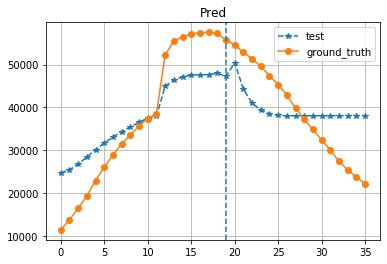

In [29]:
path = 'D:/Jupyter_Documents/ML-code/research_code/output/test'
exp_name = 'ori-stnn_05-03-16-40-00_6317'
exp_dir = {'test': exp_name}
# lambd=0.1
# exp_name = 'v2-stnn_05-03-00-05-59_0251'
# exp = Exp(exp_name, path)
# print(exp.plot_train_times().shape)
result.plot_pred_by_dir(exp_dir, path, train=True)

{'test': array([38149.02490234, 38240.74682617, 38240.74902344, 38240.74291992,
        38240.75793457, 38240.75476074, 38240.7253418 , 38240.75891113,
        38240.75805664, 38240.74450684, 38240.74707031, 38240.7701416 ,
        38240.71899414, 38240.76623535, 38240.7746582 , 38240.78759766,
        38240.76611328, 38240.74987793, 38240.76293945, 38240.75964355,
        38240.75915527, 38240.75915527, 38240.75915527, 38240.75915527,
        38240.75915527, 38240.75915527, 38240.75915527, 38240.75915527,
        38240.75915527, 38240.75915527, 38240.75915527, 38240.75915527,
        38240.75915527, 38240.75915527, 38240.75915527, 38240.75915527])}

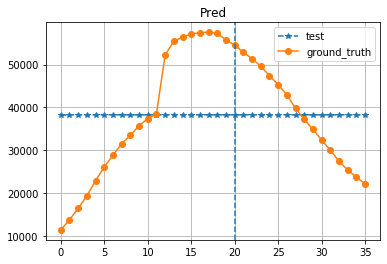

In [24]:
path = 'D:/Jupyter_Documents/ML-code/research_code/output/test'
exp_name = 'ori-stnn_05-03-17-03-31_9016'
exp_dir = {'test': exp_name}
# lambd=0.1
# exp_name = 'v2-stnn_05-03-00-05-59_0251'
# exp = Exp(exp_name, path)
# print(exp.plot_train_times().shape)
result.plot_pred_by_dir(exp_dir, path, train=True)

{'test': array([24720.16827393, 25897.2989502 , 27230.04510498, 28671.99932861,
        30434.50671387, 32021.37335205, 33426.24822998, 34758.26867676,
        35759.01416016, 36962.7520752 , 37749.01165771, 38391.45837402,
        45246.4453125 , 46836.5513916 , 47407.73162842, 47793.13867188,
        48096.42840576, 48257.84918213, 48199.42785645, 47593.60205078,
        38266.74133301, 38266.74133301, 38266.74133301, 38266.74133301,
        38266.74133301, 38266.74133301, 38266.74133301, 38266.74133301,
        38266.74133301, 38266.74133301, 38266.74133301, 38266.74133301,
        38266.74133301, 38266.74133301, 38266.74133301, 38266.74133301])}

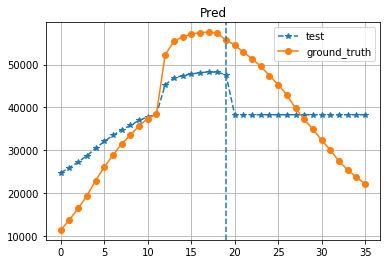

In [28]:
path = 'D:/Jupyter_Documents/ML-code/research_code/output/test'
exp_name = 'ori-stnn_05-03-17-08-35_0971'
exp_dir = {'test': exp_name}
# lambd=0 starttime=12
# exp_name = 'v2-stnn_05-03-00-05-59_0251'
# exp = Exp(exp_name, path)
# print(exp.plot_train_times().shape)
result.plot_pred_by_dir(exp_dir, path, train=True)

In [61]:
path = 'D:/Jupyter_Documents/ML-code/research_code/output/test'
exp_name = 'ori-stnn_05-03-17-11-40_0027'
exp_dir = {'test': exp_name}
# lambd=0 starttime=12
# exp_name = 'v2-stnn_05-03-00-05-59_0251'
# exp = Exp(exp_name, path)
# print(exp.plot_train_times().shape)
result.plot_pred_by_dir(exp_dir, path, train=True)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [59]:
exp = result.Exp(exp_name, path)
# model = exp.model()
# model.factors.size()
_, z = exp.generate(5)
z.sum()

TypeError: super(type, obj): obj must be an instance or subtype of type

{'test': array([11843.10299683, 15829.3772583 , 18427.5904541 , 20621.70191956,
        23505.80148315, 26584.06460571, 29391.1340332 , 31649.67356873,
        33814.19342041, 35056.08325195, 37113.0692749 , 38007.86097717,
        50315.04550171, 54493.54811096, 56064.39311218, 57225.08691406,
        57330.09803772, 57832.14590454, 57507.6794281 , 56081.9577179 ,
        59702.51446533, 54906.72070312, 49209.5602417 , 44507.08502197,
        40606.67822266, 37400.03356934, 34746.07623291, 32550.41497803,
        30772.25634766, 29364.74481201, 28290.94818115, 27492.23858643,
        26911.20062256, 26476.58740234, 26156.08654785, 25921.0814209 ])}

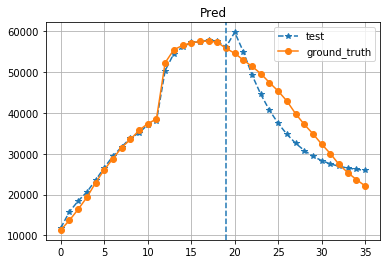

In [13]:
path = 'D:/Jupyter_Documents/ML-code/research_code/output/test'
exp_name = 'ori-stnn_05-03-18-56-30_7557'
exp_dir = {'test': exp_name}
# exp_name = 'v2-stnn_05-03-00-05-59_0251'
# exp = Exp(exp_name, path)
# print(exp.plot_train_times().shape)
result.plot_pred_by_dir(exp_dir, path, train=True)

{'test': array([ 7469.92289734,  9160.88682556, 11108.58509827, 12457.19898987,
        16340.4901886 , 17054.66061401, 16090.19309998, 23447.56573486,
        22204.13201904, 21251.42318726, 25435.27076721, 26899.44163513,
        39381.92770386, 37151.1166687 , 31468.86997986, 42120.28466797,
        36427.43688965, 37577.45896912, 43874.0713501 , 48549.74884033,
        23292.79162598, 17737.51281738, 15451.30374146, 14457.58364868,
        13883.3414917 , 13496.88223267, 13237.08578491, 13062.80685425,
        12945.88998413, 12867.45623779, 12814.83886719, 12779.54910278,
        12755.87564087, 12739.99514771, 12729.34143066, 12722.19396973])}

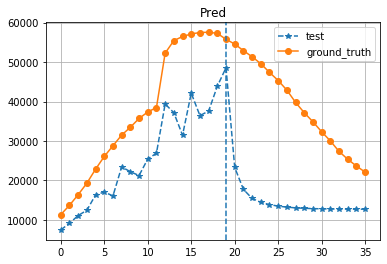

In [17]:
path = 'D:/Jupyter_Documents/ML-code/research_code/output/test'
exp_name = 'ori-stnn_05-03-19-09-12_4367'
exp_dir = {'test': exp_name}
# exp_name = 'v2-stnn_05-03-00-05-59_0251'
# exp = Exp(exp_name, path)
# print(exp.plot_train_times().shape)
result.plot_pred_by_dir(exp_dir, path, train=True)